In [20]:
from decouple import config
import os
import smote_variants
import seaborn as sns
sns.set_style('darkgrid')
import pandas as pd
from nilearn import datasets, plotting, image 
from fNeuro.connectivity.connectivity import Cyclic_analysis, connectome_plotting
import fNeuro.processing.processing as processing
from fNeuro.bayesian.bayesian import z_score_to_bayes_factor, logistic_to_bayes_factor 
from nilearn.connectome import ConnectivityMeasure
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
from fNeuro.ml.mvpa_functions import load_pickle
import glob
import warnings
warnings.filterwarnings("ignore")

In [4]:
resting_path = config('resting')
time_series = load_pickle(os.path.join(resting_path, 'measures', 'time_series'))
an_time_series = time_series['an']
hc_time_series = time_series['hc']
msdl = datasets.fetch_atlas_msdl()
msdl_overview_df = pd.DataFrame({'labels': msdl['labels'],
                                  'networks': msdl['networks'],
                                  'region_coords': msdl['region_coords']
                                  })

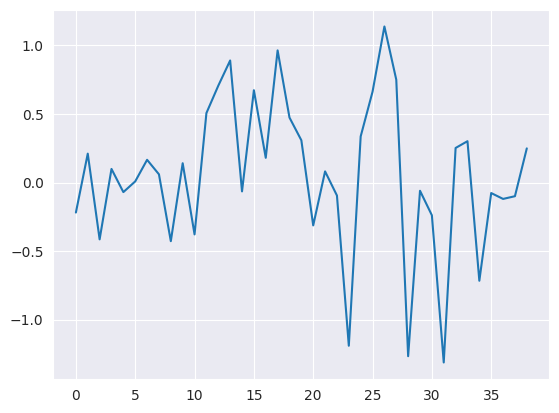

In [4]:
plt.plot(an_time_series[0][3])
plt.show()

## Get the most accurate model

Load in the models from memory

In [25]:
connectome = load_pickle(os.path.join(resting_path, 'measures', 'connectome'))
svc = load_pickle(os.path.join(resting_path, 'measures', 'svc_model'))
logistic = load_pickle(os.path.join(resting_path, 'measures', 'logistic_model'))
random_forest = load_pickle(os.path.join(resting_path, 'measures', 'random_forest_model'))
dec_tree = load_pickle(os.path.join(resting_path, 'measures', 'tree_model'))
stacked = load_pickle(os.path.join(resting_path, 'measures', 'stacked_model'))

Plot the accuracy of all  ml models

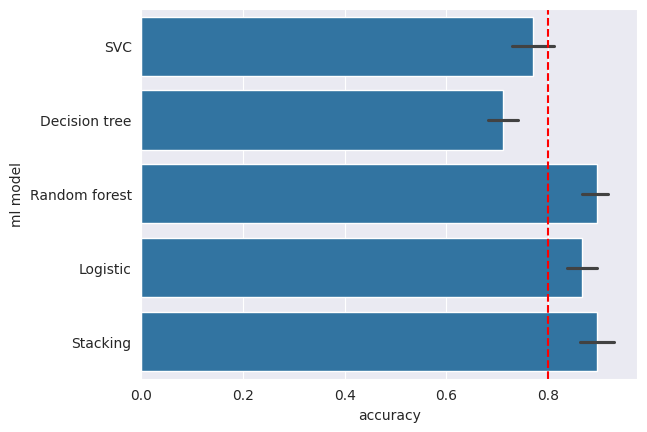

In [26]:
overal_score = {'Accuracy': pd.DataFrame(data={
                                                'SVC': svc['Accuracy'],
                                                'Decision tree': dec_tree['Accuracy'],
                                                'Random forest': random_forest['Accuracy'],
                                                'Logistic': logistic['Accuracy'],
                                                'Stacking': stacked['Accuracy'],
                                                }),
                'AUC': pd.DataFrame(data={
                                                'SVC': svc['ROC_AUC'],
                                                'Decision tree': dec_tree['ROC_AUC'],
                                                'Random forest': random_forest['ROC_AUC'],
                                                'Logistic': logistic['ROC_AUC'], 
                                                'Stacking': stacked['ROC_AUC']
                                                })
}

accuracy_plot = sns.barplot(data=pd.melt(overal_score['Accuracy']).rename(columns={'variable': 'ml model', 'value': 'accuracy'}), 
                   x='accuracy', y='ml model')
accuracy_plot.axvline(0.8, color="red", linestyle="--")

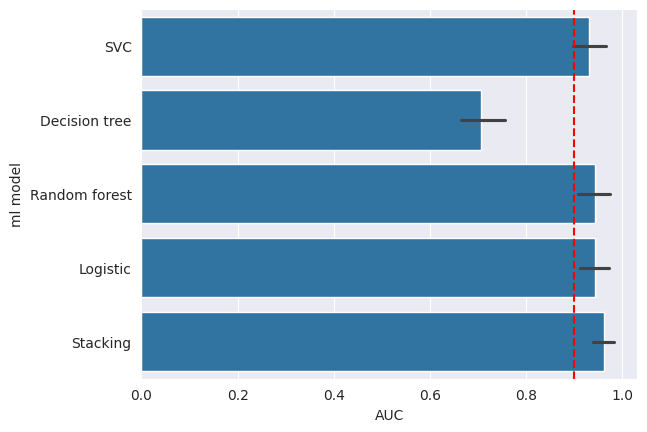

In [27]:
auc = sns.barplot(data=pd.melt(overal_score['AUC']).rename(columns={'variable': 'ml model', 'value': 'AUC'}), 
                   x='AUC', y='ml model')
auc.axvline(0.9, color="red", linestyle="--")

In [31]:
overal_score['Accuracy'].mean()

SVC              0.770370
Decision tree    0.711111
Random forest    0.896296
Logistic         0.866667
Stacking         0.896296
dtype: float64

In [32]:
overal_score['AUC'].mean()

SVC              0.930769
Decision tree    0.705769
Random forest    0.942857
Logistic         0.943956
Stacking         0.962088
dtype: float64

### Comparing cyclic analysis to other connectivity analysis

In [16]:
scores = {}
for kind in kinds:
    scores[kind] = []
    connectivity = ConnectivityMeasure(kind=kind, vectorize=True).fit_transform(group)
    oversampler= smote_variants.Assembled_SMOTE()
    cor_X, cor_y = oversampler.sample(connectivity, label)
    scores[kind].append(cross_val_score(svc, cor_X, cor_y, cv=cv, scoring='accuracy'))
scores['cyclic'] = scores_cyclic['Accuracy']

2023-10-06 11:44:15,564:INFO:Assembled_SMOTE: Running sampling via ('Assembled_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'pop': 2, 'thres': 0.3, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': None, 'class_name': 'Assembled_SMOTE'}")
2023-10-06 11:44:15,566:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-10-06 11:44:15,568:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-10-06 11:44:16,693:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-10-06 11:44:16,694:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-10-06 11:44:16,861:INFO:Assembled_SMOTE: simplex sampling with n_dim 2
2023-10-06 11:44:16,963:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-10-06 11:44:16,965:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-10-0

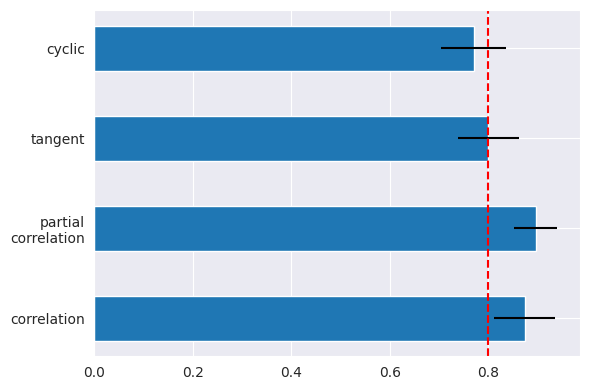

In [17]:
kinds.append('cyclic')
mean_scores = [np.mean(scores[kind]) for kind in kinds] 
scores_std = [np.std(scores[kind]) for kind in kinds] 

plt.figure(figsize=(6, 4))
positions = np.arange(len(kinds)) * 0.1 + 0.1
plt.barh(positions, mean_scores, align="center", height=0.05, xerr=scores_std)
yticks = [k.replace(" ", "\n") for k in kinds]
plt.yticks(positions, yticks)
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(0.8, color="red", linestyle="--")
plt.tight_layout()

### Examine weights and correlations

First get the full correlation matrix then get the mean correlations of group

In [18]:
full_correlation_matrix = Cyclic_analysis(to_vectorize=False).fit(group)
an_mean_correlations = pd.DataFrame(full_correlation_matrix[0:66].mean(axis = 0))
an_mean_correlations.columns = msdl['labels']
an_mean_correlations.index = msdl['labels']

hc_mean_correlations = pd.DataFrame(full_correlation_matrix[66:].mean(axis = 0))
hc_mean_correlations.columns = msdl['labels']
hc_mean_correlations.index = msdl['labels']

Get the correlation names

In [19]:
names = {
    'corr_names':[],
    'network_names': [],
    'diagonal_corr_names': [],
    'diagonal_network': []
}

for col in an_mean_correlations.columns:
    for val in range(0, len(an_mean_correlations.columns)):
        network_one = msdl_overview_df[msdl_overview_df['labels'] == col]['networks'].values[0]
        network_two = msdl_overview_df[msdl_overview_df['labels'] == an_mean_correlations.columns[val]]['networks'].values[0]
        network_string = f"{network_one} - {network_two}"
        correlation_string = f'{col} - {an_mean_correlations.columns[val]}'
        splitted_name = correlation_string.split('-')
        if splitted_name[1].lstrip() + ' - ' + splitted_name[0].rstrip() not in names['corr_names']:
            names['diagonal_corr_names'].append(correlation_string)
            names['diagonal_network'].append(network_string)
            if col != an_mean_correlations.columns[val]:
                names['corr_names'].append(correlation_string)
                names['network_names'].append(network_string)

Get the biomarker information

In [21]:
markers_df = pd.DataFrame(data={
                            'correlation_names': names['corr_names'],
                            'network': names['network_names'],
                            'rf_importance': stacked_estimator.named_estimators_.rf.feature_importances_,
                              })
markers_df['log_coeffiecents'] = stacked_estimator.named_estimators_.log.coef_.T
markers_df['Bayes'] = markers_df['log_coeffiecents'].apply(lambda coef: logistic_to_bayes_factor(coef))

Segregate the biomarker dataframe by network 

In [22]:
network_values = dict(zip([network for network in msdl_overview_df['networks'].unique()], 
                          [{} for network in msdl_overview_df['networks'].unique()]))
for network in network_values.keys():
    network_df = markers_df[markers_df['network'].str.startswith(network)]
    within_network_df = network_df[network_df['network'] == f'{network} - {network}'] 
    between_network_df = network_df.drop(within_network_df.index).reset_index(drop=True) 
    network_values[network]['within'] = within_network_df
    network_values[network]['between'] = between_network_df

Calculate the mean of each network and between each network

In [23]:
within_network = dict(zip([network for network in msdl_overview_df['networks'].unique()], 
                          [{} for network in msdl_overview_df['networks'].unique()]))
for get_mean in network_values.keys():
    if len(network_values[get_mean]['within']) > 0:
        within_network[get_mean]['rf_importance'] = network_values[get_mean]['within'].mean()[0]
        within_network[get_mean]['log_coeffiecents'] = network_values[get_mean]['within'].mean()[1]

between_network_list  =[network_values[df]['between'] for df in network_values.keys()]
between_network = pd.concat(between_network_list).reset_index(drop=True)

In [28]:
within_network_df = pd.DataFrame(within_network).T.dropna()
within_network_df = processing.df_with_transformed_values(within_network_df)
most_predicitive_within_network = processing.get_max_value(within_network_df)
most_predicitive_within_network

,rf_importance,log_coeffiecents,z_score_transformation_rf,z_score_transformation_log
Salience,0.003794,-0.005662,2.786423,-0.295336


In [29]:
within_network_prediction = network_values[most_predicitive_within_network.index[0]]['within']
within_network_prediction = processing.df_with_transformed_values(within_network_prediction)
most_predicitive_within_network_node = processing.get_max_value(within_network_prediction)
most_predicitive_within_network_node

,correlation_names,network,rf_importance,log_coeffiecents,Bayes,z_score_transformation_rf,z_score_transformation_log
621,V ACC - R A Ins,Salience - Salience,0.009519,-0.015386,1.000118,1.40929,-1.305089


In [30]:
between_network_df = processing.df_with_transformed_values(between_network)
most_predicitive_between_network = processing.get_max_value(between_network_df)
most_predicitive_between_network

,correlation_names,network,rf_importance,log_coeffiecents,Bayes,z_score_transformation_rf,z_score_transformation_log
142,Med DMN - Occ post,DMN - Occ post,0.017685,-0.022843,1.000261,8.182305,-2.266268


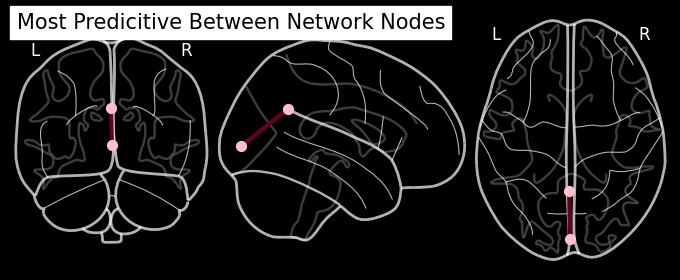

In [52]:
plot_parameters = connectome_plotting(most_predicitive_between_network, 'z_score_transformation_rf', msdl_overview_df)
plotting.plot_connectome(plot_parameters['adj'], 
                         plot_parameters['coords'],   
                         node_color='pink',
                         node_size=50,
                         edge_cmap='PuRd',
                         black_bg=True, 
                         title='Most Predicitive Between Network Nodes')

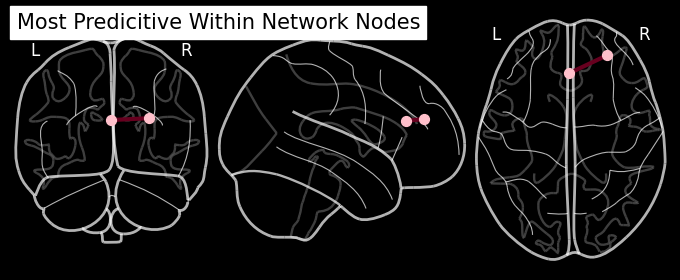

In [50]:
plot_parameters = connectome_plotting(most_predicitive_within_network_node, 'z_score_transformation_rf', msdl_overview_df)
plotting.plot_connectome(plot_parameters['adj'], 
                         plot_parameters['coords'],   
                         node_color='pink',
                         node_size=50,
                         edge_cmap='PuRd',
                         black_bg=True, 
                         title='Most Predicitive Within Network Nodes')

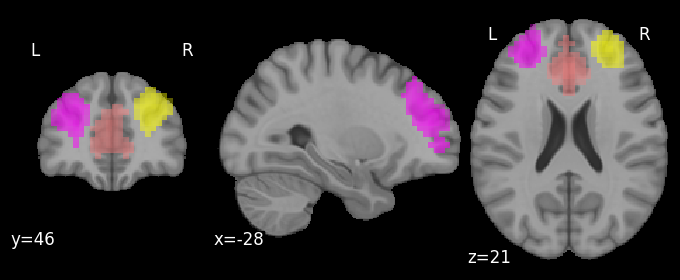

In [99]:
plotting.plot_prob_atlas(
    image.index_img(
        msdl['maps'], 
        msdl_overview_df[msdl_overview_df['networks'].str.contains(most_predicitive_within_network.index[0])].index.to_list()
        ),
    draw_cross=False,
    black_bg=True,
    cut_coords=msdl_overview_df[msdl_overview_df['networks'].str.contains(most_predicitive_within_network.index[0])]['region_coords'].to_list()[0],
    cmap='spring',
    title='Most predicitive network'
)


Sort out the AN and HC correlations into one DataFrame 

In [37]:
an_corr_df = pd.DataFrame(connectome[0:66])
an_corr_df.columns = names['corr_names']
hc_corr_df = pd.DataFrame(connectome[66:])
hc_corr_df.columns = names['corr_names']

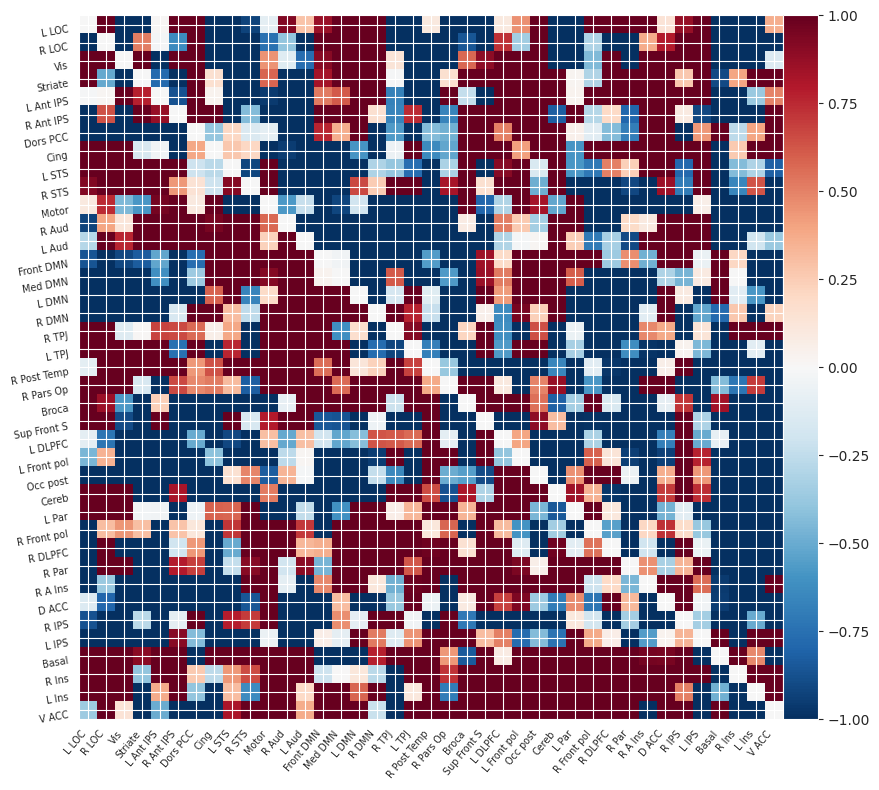

In [38]:
plotting.plot_matrix(
    an_mean_correlations.values,
    figure=(10, 8),
    labels=msdl['labels'],
    vmax=1,
    vmin=-1,
    reorder=True,
)

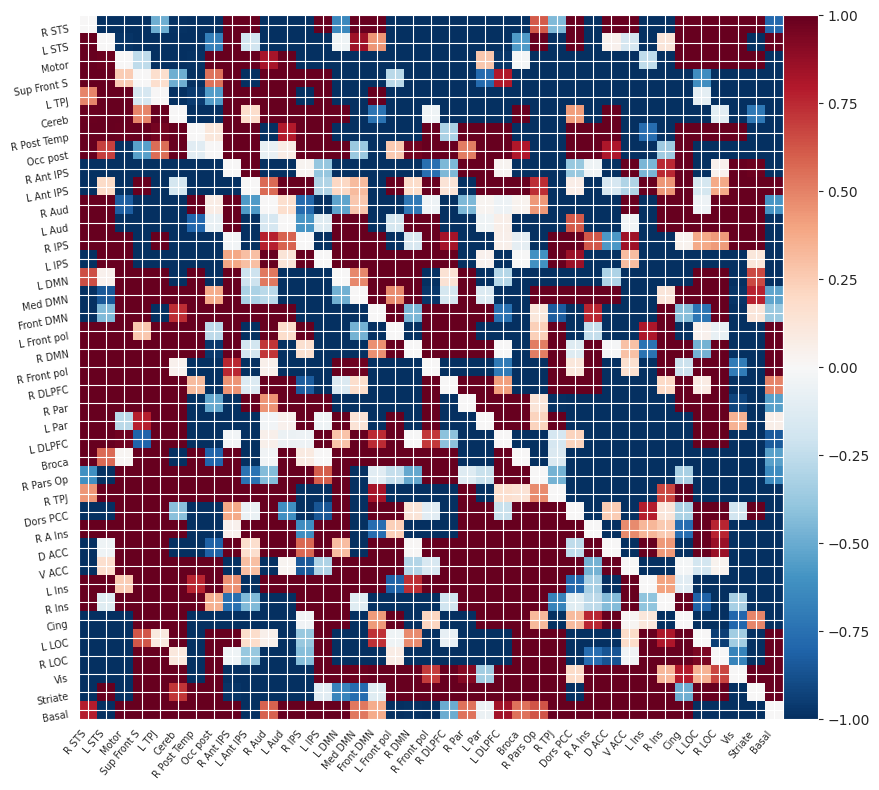

In [39]:
plotting.plot_matrix(
    hc_mean_correlations.values,
    figure=(10, 8),
    labels=msdl['labels'],
    vmax=1,
    vmin=-1,
    reorder=True,
)

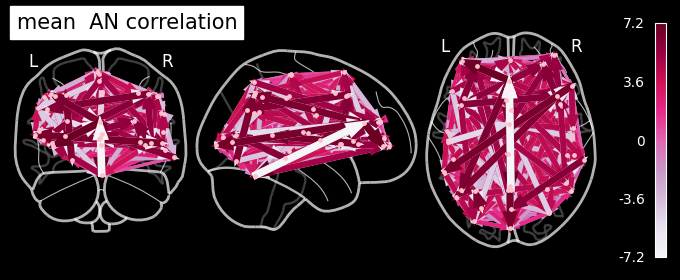

In [40]:
plotting.plot_connectome(
    an_mean_correlations.values,
    msdl['region_coords'],
    title="mean  AN correlation",
    node_color='pink',
    node_size=6,
    edge_cmap='PuRd',
    black_bg=True,
    colorbar=True
)

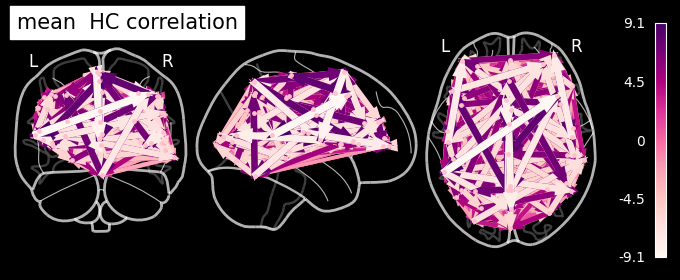

In [41]:
plotting.plot_connectome(
    hc_mean_correlations.values,
    msdl['region_coords'],
    title="mean  HC correlation",
    node_color='pink',
    node_size=6,
    edge_cmap='RdPu',
    black_bg=True,
    colorbar=True
)